# 1. Import

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from basic_functions import data_load, save_df, get_base_path

In [115]:
X_train = data_load("data/X_train.csv")
y_train = data_load("data/y_train.csv")


Data loaded!
Data loaded!


In [116]:
X_train["job_major"] = X_train["job"].astype(str).str[0]

# 2. Exploration of original Target Classes (Income)

In [134]:
y_train.describe()

,income
count,10376.000000
mean,2.428489
std,1.690425
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,6.000000


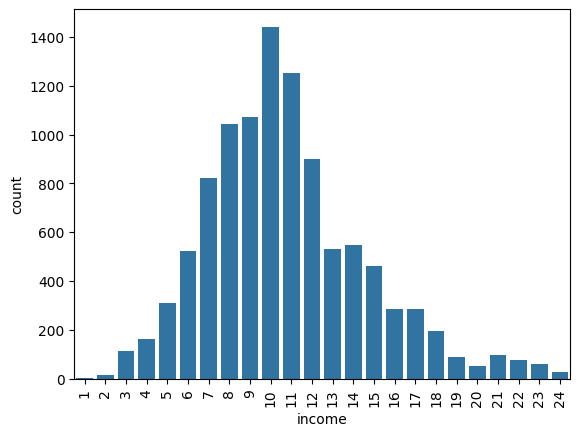

In [118]:
sns.countplot(
    data = y_train,
    x="income"
)
plt.tick_params(axis="x", rotation=90)

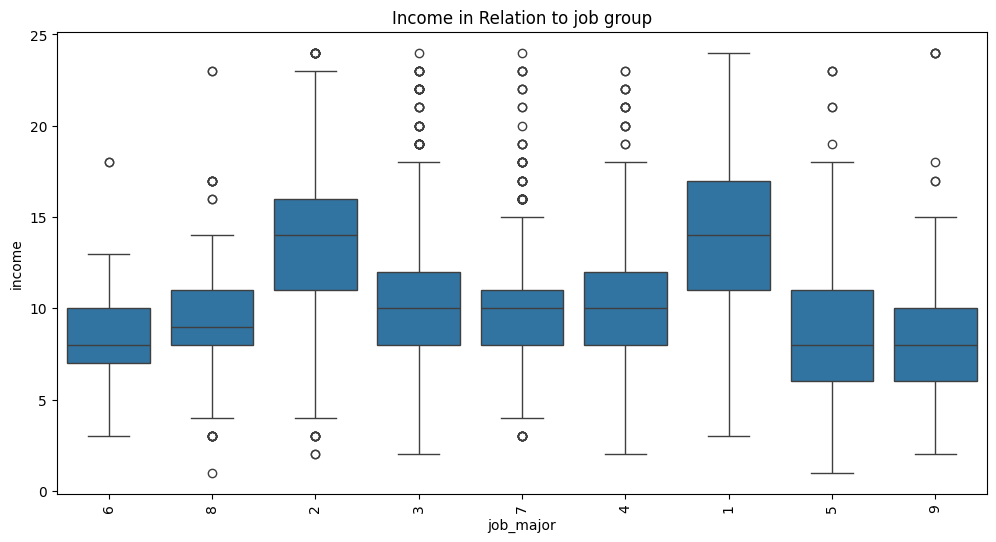

In [119]:
df = X_train.copy()
df["income"] = y_train

# Beispiel: Boxplot Einkommen nach Beruf
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="job_major", y="income")
plt.xticks(rotation=90)
plt.title("Income in Relation to job group")
plt.show()

To improve the results and provide more meaningful insights, I want to consolidate the income classes into 3 to 5 broader categories, such as "low," "medium," and "high."

# 3.  K-Means Clustering Target Class


## 3.1 Testing different K

In [120]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
income_classes = np.arange(1,25).reshape(-1, 1)
counts = y_train.value_counts().sort_index()
silhouette_scores =[]
for i in range(3,11):
    kmeans = KMeans(n_clusters=i, n_init=100, random_state=42)
    kmeans.fit(income_classes,sample_weight=counts)
    mapping = {cls: lab for cls, lab in zip(income_classes.flatten(), kmeans.labels_)}
    boundaries = [c for c in range(2, 25) if mapping[c] != mapping[c-1]]
    labels = kmeans.labels_
    income_to_cluster = {cls:cluster for cls, cluster in zip(income_classes.flatten(),labels)}

    X_obs = y_train["income"].values.reshape(-1, 1)
    labels_obs = y_train["income"].map(income_to_cluster).values


    sil = silhouette_score(X_obs, labels_obs)                
    dbi = davies_bouldin_score(X_obs, labels_obs)            
    chi = calinski_harabasz_score(X_obs, labels_obs)         
    print(f"K={i} | Silhouette: {sil:.3f} | Davies-Bouldin: {dbi:.3f} | Calinski-Harabasz: {chi:.1f} | Grenzen: {boundaries}")
    silhouette_scores.append(sil)


K=3 | Silhouette: 0.559 | Davies-Bouldin: 0.566 | Calinski-Harabasz: 22333.5 | Grenzen: [10, 15]
K=4 | Silhouette: 0.580 | Davies-Bouldin: 0.537 | Calinski-Harabasz: 27305.5 | Grenzen: [9, 13, 18]
K=5 | Silhouette: 0.581 | Davies-Bouldin: 0.537 | Calinski-Harabasz: 32734.3 | Grenzen: [8, 11, 14, 18]
K=6 | Silhouette: 0.598 | Davies-Bouldin: 0.506 | Calinski-Harabasz: 39406.6 | Grenzen: [7, 10, 12, 15, 19]
K=7 | Silhouette: 0.643 | Davies-Bouldin: 0.496 | Calinski-Harabasz: 49635.5 | Grenzen: [7, 9, 11, 13, 16, 20]
K=8 | Silhouette: 0.658 | Davies-Bouldin: 0.495 | Calinski-Harabasz: 57736.5 | Grenzen: [6, 8, 10, 12, 14, 16, 20]
K=9 | Silhouette: 0.679 | Davies-Bouldin: 0.481 | Calinski-Harabasz: 64185.8 | Grenzen: [6, 8, 10, 11, 13, 15, 17, 20]
K=10 | Silhouette: 0.718 | Davies-Bouldin: 0.458 | Calinski-Harabasz: 69532.6 | Grenzen: [5, 7, 9, 10, 11, 13, 15, 17, 20]


## 3.2 Sihouette Score Plotting and detailed Silouette Plot 

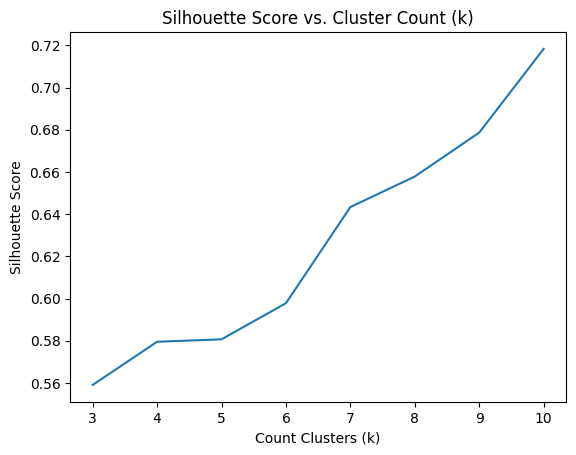

In [121]:
plt.plot(range(3,11), silhouette_scores)
plt.title("Silhouette Score vs. Cluster Count (k)")
plt.xlabel("Count Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

## 3.3 Final K-Means Clustering Model

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# --- Vorbereitung ---
income_classes = np.arange(1, 25).reshape(-1, 1)   # 1..24
y_series = y_train["income"].squeeze()
counts = y_series.value_counts().sort_index()
counts.index = counts.index.astype(int)
sample_weights = counts.reindex(range(1, 25), fill_value=0).values

n_clusters = 7

# --- KMeans auf Klassen mit Gewichten ---
kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
kmeans.fit(income_classes, sample_weight=sample_weights)

# Zentren sortieren (niedrig -> hoch) und Labels umcodieren
centers = kmeans.cluster_centers_.flatten()
order = np.argsort(centers)                           # z.B. [3,1,2,0]
label_map = {old: new for new, old in enumerate(order)}

# Klassenlabels (pro Einkommensklasse) nach der Sortierung
labels_per_class_sorted_km = np.array([label_map[l] for l in kmeans.labels_])

# Mapping Klasse -> sortiertes Cluster
income_to_cluster_sorted_km = {
    cls: lab for cls, lab in zip(income_classes.flatten(), labels_per_class_sorted_km)
}



In [123]:
# Daten auf Beobachtungsebene
y_series = y_train["income"]
X_obs = y_series.values.reshape(-1, 1)
labels_obs = y_series.map(income_to_cluster_sorted_km).values

# Silhouette-Werte pro Beobachtung
sil_values = silhouette_samples(X_obs, labels_obs)

# Durchschnittlicher Silhouette-Score
avg_score = silhouette_score(X_obs, labels_obs)
print(f"Average Silhouette Score: {avg_score:.3f}")

Average Silhouette Score: 0.643


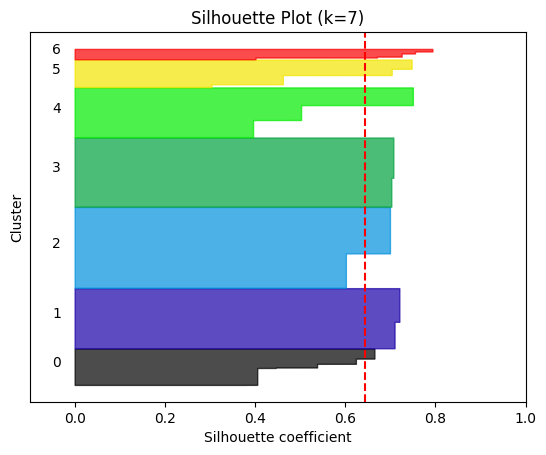

In [124]:
# --- Plot ---
fig, ax1 = plt.subplots(1, 1)

y_lower = 10
for i in range(n_clusters):
    cluster_sil_values = sil_values[labels_obs == i]
    cluster_sil_values.sort()
    size_cluster = cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_sil_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10  # Lücke zwischen Clustern

ax1.axvline(x=avg_score, color="red", linestyle="--")
ax1.set_title(f"Silhouette Plot (k={n_clusters})")
ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster")
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
plt.show()

## 3.4 Plot Cluster Assignment

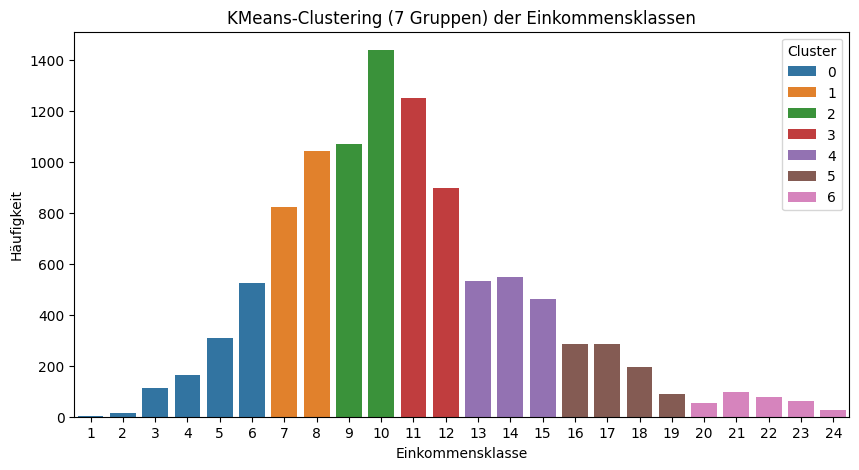

In [125]:
plt.figure(figsize=(10, 5))
sns.barplot(x=income_classes.flatten(), y=counts, hue=labels_per_class_sorted_km, dodge=False, palette='tab10')
plt.xlabel('Einkommensklasse')
plt.ylabel('Häufigkeit')
plt.title(f'KMeans-Clustering ({n_clusters} Gruppen) der Einkommensklassen')
plt.legend(title='Cluster')
plt.show()

# 4. GMM Clustering Target Class

## 4.1 Testing for different K

In [126]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [127]:
BIC_score_list = []
AIC_score_list = []
for i in range(3,11):

    gmm = GaussianMixture(n_components=i, covariance_type="full", random_state=42)
    gmm.fit(y_train)

    gmm_probs = gmm.predict_proba(income_classes)

    labels_per_class = gmm.predict(income_classes)

    BIC_score_list.append(gmm.bic(y_train))
    AIC_score_list.append(gmm.aic(y_train))


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\proje

## 4.2 Model Comparison

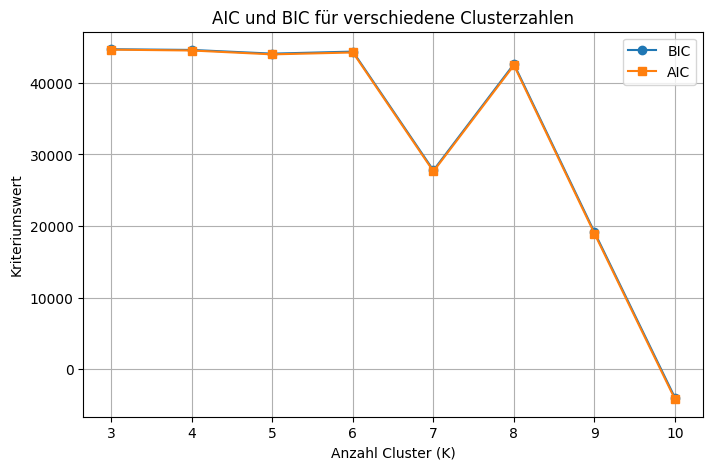

In [128]:
plt.figure(figsize=(8,5))
plt.plot(range(3,11),BIC_score_list, marker="o", label="BIC")
plt.plot(range(3,11),AIC_score_list, marker="s", label="AIC")
plt.xlabel("Anzahl Cluster (K)")
plt.ylabel("Kriteriumswert")
plt.title("AIC und BIC für verschiedene Clusterzahlen")
plt.legend()
plt.grid(True)
plt.show()

## 4.3 Final GMM-Clustering Model 

In [129]:
gmm = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=42)
gmm.fit(y_train)

gmm_probs = gmm.predict_proba(income_classes)

labels_per_class = gmm.predict(income_classes)
# Zentren = Mittelwerte der Komponenten
centers = gmm.means_.flatten()
order = np.argsort(centers)  # klein → groß
label_map = {old: new for new, old in enumerate(order)}

# Sortierte Labels für jede Einkommensklasse
labels_per_class_sorted_gmm = np.array([label_map[l] for l in labels_per_class])
income_to_cluster_sorted_gmm = {
    cls: lab for cls, lab in zip(income_classes.flatten(), labels_per_class_sorted_gmm)
}

# Auf Beobachtungsebene anwenden
labels_obs = y_series.map(income_to_cluster_sorted_gmm).values

gmm_probs_sorted = gmm_probs[:, order]

c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


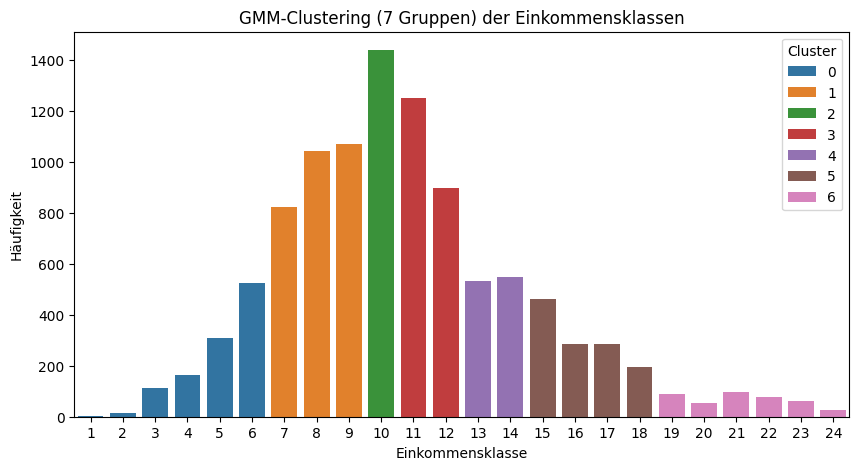

In [130]:
plt.figure(figsize=(10, 5))
sns.barplot(x=income_classes.flatten(), y=counts, hue=labels_per_class_sorted_gmm, dodge=False, palette='tab10')
plt.xlabel('Einkommensklasse')
plt.ylabel('Häufigkeit')
plt.title(f'GMM-Clustering ({n_clusters} Gruppen) der Einkommensklassen')
plt.legend(title='Cluster')
plt.show()

In [131]:
gmm_prob_df = pd.DataFrame(gmm_probs_sorted)
gmm_prob_df = gmm_prob_df.round(2) * 100

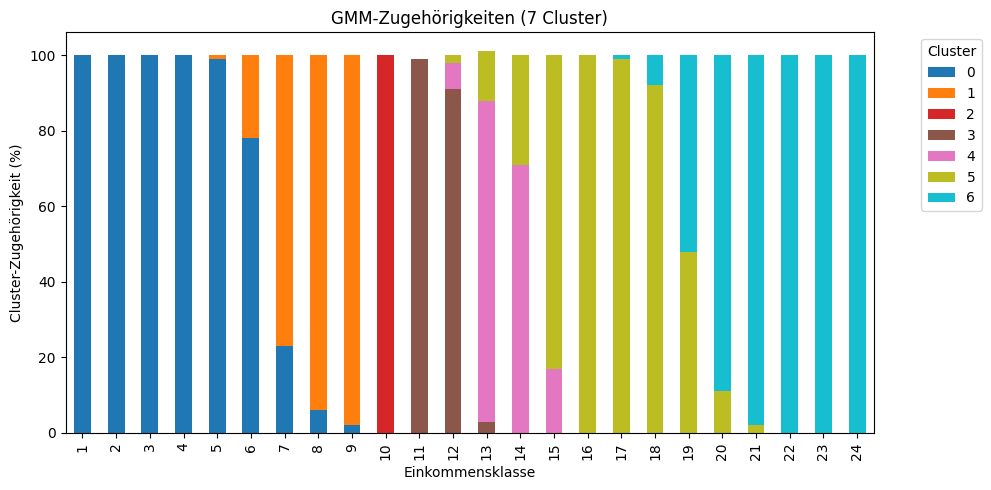

In [132]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))
gmm_prob_df.plot(kind="bar", stacked=True, ax=ax, cmap="tab10")

ax.set_xlabel("Einkommensklasse")
ax.set_ylabel("Cluster-Zugehörigkeit (%)")
ax.set_title(f"GMM-Zugehörigkeiten ({gmm.n_components} Cluster)")
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(ticks=range(24), labels=range(1, 25))
plt.tight_layout()
plt.show()

# 5. Apply Labels on Test Data

In [133]:
# Income-Classes 1–24
income_classes = np.arange(1, 25)

# Mapping Income Class -> Cluster
income_to_cluster = dict(zip(income_classes, labels_per_class_sorted_gmm))

#Income -> Cluster
y_test = data_load("data/y_test.csv")
y_test["income"] = y_test["income"].map(income_to_cluster)
print(f"after Clustering: {y_test['income'].unique()}")

y_train = data_load("data/y_train.csv")
y_train["income"] = y_train["income"].map(income_to_cluster)
print(f"after Clustering: {y_train['income'].unique()}")

save_df(y_test, "data/y_test_clustered.csv")
save_df(y_train, "data/y_train_clustered.csv")

Data loaded!
after Clustering: [1 2 3 0 4 5 6]
Data loaded!
after Clustering: [1 2 3 0 4 5 6]
Data saved!
Data saved!
